# Programming Assignment 1: Data Preparation and Understanding

# Imports


In [144]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # To use local CPU instead of local GPU
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as implt
from PIL import Image 
import glob
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.datasets import load_files
from io import BytesIO
import seaborn as sns
import xml.etree.ElementTree as ET
from pathlib import Path



## 1. Introduction
In this semester, we will be using the “Stanford Dogs” dataset (http://vision.stanford.edu/aditya86/ImageNetDogs/) for all our 4 programming assignments. There are a total of 120 classes (dog breeds). The number of images for each class ranges from 148 to 252. Each student will:
- (a) be assigned 4 classes to work on the 4 assignments.

- Classes names  Cairn ,  Austrilan Terrer , English setter , Great pyreness
  
- (b) download Images (and also Annotations - bounding boxes) datasets for the 4 classes to work on.
- (c) create a Github account to share (as collaborator) their solution (Readme, Codes, Processed Dataset for Code to run correctly) with the grader.


## 2. Image Processing
### (a) Cropping and Resize Images
Use XML processing modules ([XML Processing](https://docs.python.org/3/library/xml.html)) to obtain bounding box information from Annotations datasets and scikit-Image ([scikit-image](https://scikit-image.org/)) to perform image processing and feature extraction.

In [83]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
dog_images = glob.glob('./image/*/*')
breeds = glob.glob('./anno/*')
annotations = glob.glob('./anno/*/*')
cropped = "./Cropped/"
img_size = 299 # For Xception input
train_dir = './Cropped' # './Images'
batch_size_training = 256
batch_size_validation = 256
input_shape = (img_size,img_size,3)



######## Read X and Y coordinate ranges from an annotation ########
def get_bounding_boxes(annot):
    xml = annot
    tree = ET.parse(xml)
    root = tree.getroot()
    objects = root.findall('object')
    bbox = []
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bbox.append((xmin,ymin,xmax,ymax))
    return bbox

######## Get image path from annotation path ########
def get_image(annot):
    img_path = './image/'
   
    file = annot.split('\\')
    
    
   
    img_filename = img_path + file[-2] +'/'+file[-1]+'.jpg'
    return img_filename

######## Fill image with black to make a square (not used) ########
def make_square(im, min_size=100, fill_color=(0, 0, 0, 0)):
    x, y = im.size
    size = max(min_size, x, y)
    new_im = Image.new('RGB', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    return new_im


print(len(dog_images), len(breeds), len(annotations))

767 4 767


## Plot a few dogs from the dataset
Aspect ratio will get streched a bit. It produces better results than filling the space needed to resize to square.

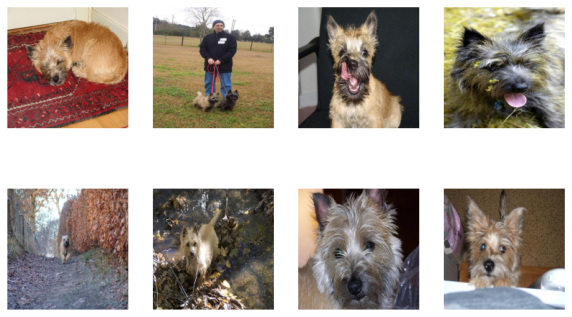

In [84]:
plt.figure(figsize=(10,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.axis("off")
    dog = get_image(annotations[i])
    im = Image.open(dog)
    im = im.resize((256,256), Image.Resampling.LANCZOS)
    plt.imshow(im)

# Crop Dogs From Files
Use bounding box annotations from the dataset in order to crop images. Sometimes extracting more than 1 dog per image.
Cropped files could be moved as permanent input data for this notebook, but I'm leaving it here for academic purposes.

In [85]:
plt.figure(figsize=(10,6))
for i in range(len(dog_images)):
    bbox = get_bounding_boxes(annotations[i])
    dog = get_image(annotations[i])
    im = Image.open(dog)
    for j in range(len(bbox)):
        im2 = im.crop(bbox[j])
        im2 = im2.resize((128,128), Image.Resampling.LANCZOS)
        new_path = dog.replace('./image/','./Cropped/')
        new_path = new_path.replace('.jpg','-' + str(j) + '.jpg')
        im2=im2.convert('RGB')
        head, tail = os.path.split(new_path)
        Path(head).mkdir(parents=True, exist_ok=True)
        im2.save(new_path)

<Figure size 1000x600 with 0 Axes>

Feature Extraction: Edge Histogram and Similarity Measurements
Choose 1 image from each class.
Convert the color images to grayscale images (Grayscale Conversion).
For each image 
𝐼
I, calculate the angle:

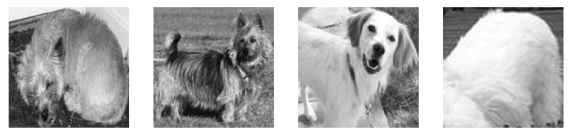

In [145]:
### Choose 1 image from Each class
import random
import matplotlib.pyplot as plt
import numpy as np
from skimage import filters
from skimage.color import rgb2gray


breeds = glob.glob('./Cropped/*')

## CHoosing Random image fromeach class

def random_image_breeds(breeds):
    random_images = []

    for folder in breeds:

        image_files = [f for f in os.listdir(folder)]
        if image_files:

            random_image = random.choice(image_files)

            random_images.append(os.path.join(folder,random_image))
    return random_images

images = random_image_breeds(breeds)



plt.figure(figsize=(10,6))

    
   

## Coverting images in to GrayScale 

def convtogray(image_path):
    image = np.array(Image.open(image_path).convert('RGB'))
    gray_image = rgb2gray(image)
    return gray_image

gray_images = []
for index,image in enumerate(images):
    plt.subplot(2,4,index+1)
    plt.axis("off")
    gray_image = convtogray(image)
    plt.imshow(gray_image,cmap='gray')
    gray_images.append(gray_image)
    


"""Calculate the angles between horizontal and vertical operators."""

def angle(dx, dy):
    return np.mod(np.arctan2(dy, dx), np.pi)

angles = []
for I in gray_images:
    angle_sobel = angle(filters.sobel_h(I),filters.sobel_v(I))
    angles.append(angle_sobel)



--> Obtain a histogram with 36 bins using skimage.exposure.histogram (Histogram Documentation).

--> Plot the images with their corresponding edge histogram values (add x-axis label “Bins” and y-axis label “Pixel Count”).

--> Pick 2 edge histograms from the 4 you have constructed and perform histogram comparison using:
--> Euclidean distance
--> Manhattan distance
--> Cosine distance (1.5 points)

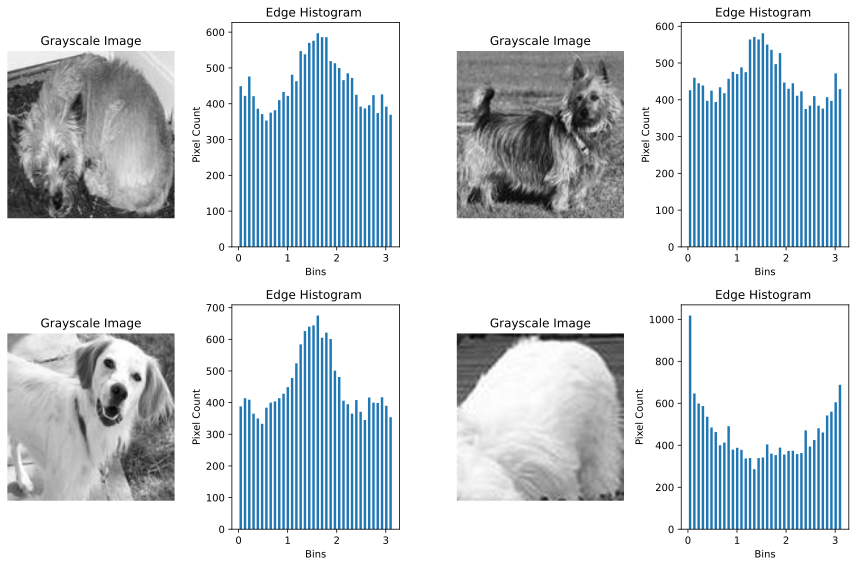

In [146]:
# v. Use skimage.exposure.histogram (see https://scikit-image.org/docs/stable/api/
# skimage.exposure.html#skimage.exposure.histogram) to obtain a histogram with 36
# bins.
# v. Plot the images with their corresponding edge histogram values (add x-axis label “Bins” and
# y-axis label “Pixel Count” ). (2 points)
# vi. Pick 2 edge histograms from the 4 you have constructed (These are the vector representations
# of the images)
# • Perform histogram comparison between the 2 edge histograms using the following metrics/measures. (see https://scikit-learn.org/stable/modules/generated/sklearn.
# metrics.pairwise.distance_metrics.html#sklearn.metrics.pairwise.distance_
# metrics)
# – Euclidean distance
# – Manhattan distance
# – Cosine distance
# (1.5 points)

from skimage import exposure

# Assuming gray_images is a list of grayscale images and angles is a list of angle arrays
# Calculating histograms with 36 bins
hist_images = []
bins_centers = []

for angle in angles:
    hist, hist_center = exposure.histogram(angle, nbins=36)
    hist_images.append(hist)
    bins_centers.append(hist_center)

# Set up a figure for displaying the images and histograms
count = 1
plt.figure(figsize=(12, 8))

# Iterate over grayscale images and their corresponding histograms
for gray_image, hist, hist_center in zip(gray_images, hist_images, bins_centers):
    plt.subplot(2, len(gray_images), count)
    plt.imshow(gray_image, cmap='gray')
    plt.axis('off')
    plt.title(f'Grayscale Image')
    
    count += 1
    
    plt.subplot(2, len(gray_images), count)
    plt.bar(hist_center, hist, width=0.05)
    plt.xlabel("Bins")
    plt.ylabel("Pixel Count")
    plt.title(f"Edge Histogram ")
    
    count += 1

plt.tight_layout()
plt.show()



In [147]:
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_distances

hist1 = hist_images[0]  # Histogram 1
hist2 = hist_images[1]  # Histogram 2

# Reshape histograms as 2D arrays for pairwise distance calculation
hist1 = np.array(hist1).reshape(1, -1)
hist2 = np.array(hist2).reshape(1, -1)



# Calculate Euclidean distance
euclidean_dist = euclidean_distances(hist1, hist2)
print(f"Euclidean Distance is : {euclidean_dist[0][0]}")

# Calculate Manhattan distance
manhattan_dist = manhattan_distances(hist1, hist2)
print(f"Manhattan Distance is : {manhattan_dist[0][0]}")

# Calculate Cosine distance
cosine_dist = cosine_distances(hist1, hist2)
print(f"Cosine Distance is : {cosine_dist[0][0]}")




Euclidean Distance is : 261.69829957414703
Manhattan Distance is : 1346.0
Cosine Distance is : 0.004492667419009444


(c) Histogram of Oriented Gradient (HOG)
Pick 1 image and compute its HOG descriptors.
Visualize the image and the HOG descriptors for the image (HOG Visualization). (1 point)

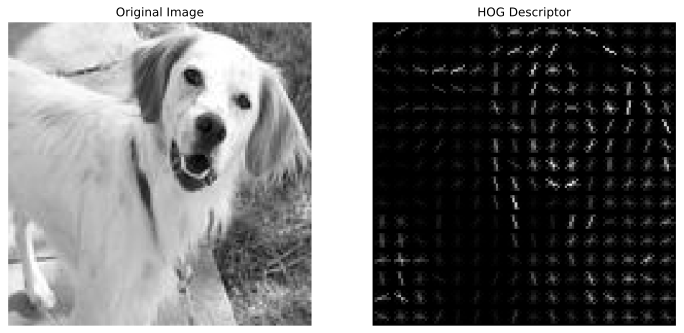

In [153]:
import matplotlib.pyplot as plt
from skimage import data, color, feature, io
from skimage.transform import resize





image = gray_images[2]

# Compute HOG descriptors and HOG image
hog_descriptor, hog_image = feature.hog(image, orientations=9, pixels_per_cell=(8, 8),
                                        cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')

# Plot the original image and HOG descriptor
plt.figure(figsize=(12, 6))

# Plot original grayscale image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Plot HOG descriptor image
plt.subplot(1, 2, 2)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Descriptor')
plt.axis('off')

plt.show()


(d) Dimensionality Reduction using PCA
Use images from all four classes.
Convert all the images from the four classes to edge histograms.
Perform Principal Component Analysis (PCA) dimensionality reduction on the set of histograms to reduce from 36 to 2 dimensions.
Plot the 2D points using four different colors for data from the four classes. How many classes are visually separable (i.e., non-overlapping)?

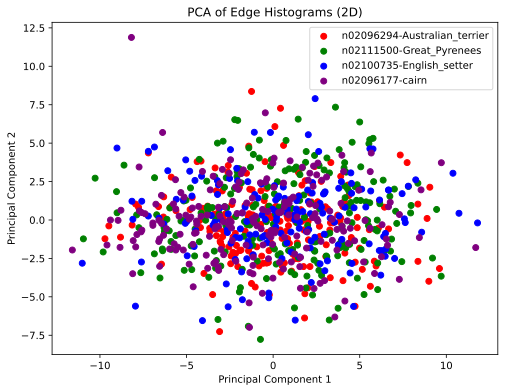

In [154]:
#### 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# 1) i. Use images from all four classes.

image_paths = glob.glob("./Cropped/*/*.jpg")

## 
# 2) Gray images conversion

gray_images = [convtogray(image) for image in image_paths]


def angle(dx, dy):
    return np.mod(np.arctan2(dy, dx), np.pi)


## 3 edge histograms

def compute_edge_histogram(image):
    
    angle_sobel = angle(filters.sobel_h(image),filters.sobel_v(image))
    hist, hist_center = exposure.histogram(angle_sobel, nbins=36)
    return hist


edge_histograms = np.array([compute_edge_histogram(image) for image in gray_images])
### 

## Perform Principal Component Analysis (PCA) to reduce dimensions

# 

scaler = StandardScaler()

scaled_histograms = scaler.fit_transform(edge_histograms)

pca = PCA(n_components=2)

pca_histograms = pca.fit_transform(scaled_histograms)


### Plot the pca_histograms

# Assuming we have 4 classes, create color labels
# This will assign a color for each class based on the image folder names
import os

classes = [os.path.split(os.path.dirname(image))[1] for image in image_paths]
unique_classes = list(set(classes))
colors = ['red', 'green', 'blue', 'purple']  # Colors for the four classes

# Create a color map for the classes
color_map = {cls: colors[i] for i, cls in enumerate(unique_classes)}
point_colors = [color_map[cls] for cls in classes]


# Plot the PCA-reduced 2D points
plt.figure(figsize=(8, 6))
for i, cls in enumerate(unique_classes):
    idx = [j for j, c in enumerate(classes) if c == cls]
    plt.scatter(pca_histograms[idx, 0], pca_histograms[idx, 1], c=colors[i], label=cls)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Edge Histograms (2D)")
plt.legend(loc='best')
plt.show()



    





#### No class is Visually Seperable 

In [156]:

print("PCA ratio is for 2 components",pca.explained_variance_ratio_)

PCA ratio is for 2 components [0.4951176 0.1774501]


3. Text Processing Steps on Tweet Dataset
The dataset file is in JSON format and consists of:

Training Set: 3,000 records
Test Set: 1,500 records
Validation Set: 400 records This is a multi-class dataset with eleven classes: (‘anger’, ‘anticipation’, ‘disgust’, ‘fear’, ‘joy’, ‘love’, ‘optimism’, ‘pessimism’, ‘sadness’, ‘surprise’, ‘trust’).

In [116]:
### 
### Reading Training dataset 
import json
import pandas as pd


# Normalize the data (useful for nested JSON)
train_set = pd.read_json("./student_8/train.json",lines=True)
train_frame = pd.DataFrame(train_set)


train_frame.head()



,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-En-31496,i animated a little thing i might post it tomo...,False,True,False,False,True,False,True,False,False,False,False
1,2017-En-21736,My wedding is in two weeks and I'm actually re...,False,True,False,True,False,False,False,True,True,False,False
2,2017-En-21372,@ddcl2519 @ABC not nice. Wishing harm on anot...,True,False,True,False,False,False,False,True,True,False,False
3,2017-En-10879,@TrueAggieFan oh so that's where Brian was! Wh...,True,True,False,False,False,False,False,False,False,False,False
4,2017-En-21922,#Peiyophobilia :) An advice from @anirudhoffic...,False,False,False,True,False,False,True,False,False,False,False


4. Vectorization
You will use the simple CountVectorizer and TfidfVectorizer to extract token (feature) counts and TF-IDF feature counts, respectively. What are the dimensionalities of the two vector representations?

5. Analysis of Processed Text Data
Pick four classes that you think will be separable.
Perform dimensionality reduction similar to 2(d) with dimensionality reduced to 2.
Plot the 2D points using four different colors for data from the four classes for both token count features and TF-IDF features in two separate plots.
How many classes are visually separable (i.e., non-overlapping) for both plots?

In [157]:
### countvectorizer and tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

tweet_set = train_frame["Tweet"]

countvector = CountVectorizer()
tfidvector = TfidfVectorizer()

count_matrix = countvector.fit_transform(tweet_set)
tf_matrix = tfidvector.fit_transform(tweet_set)

print(f"Dimensionality of CountVectorizer representation: {count_matrix.shape}")

print(f"Dimensionality of TfidfVectorizer representation: {tf_matrix.shape}")

Dimensionality of CountVectorizer representation: (3000, 9583)
Dimensionality of TfidfVectorizer representation: (3000, 9583)


In [160]:
# 5. Using the two sets of processed text data in Item 4,
# • Pick four classes which you think will be separable. State the four classes.


    # The four classes I picked is anger , joy, fear , sadness

### Perform PCA 


filtered_data = train_frame[train_frame[['joy', 'anger', 'fear', 'sadness']].any(axis=1)]

# Extract the tweets and labels
tweets = filtered_data['Tweet']
labels = filtered_data[['joy', 'anger', 'fear', 'sadness']].idxmax(axis=1) 

### dimension reduction 

count_matrix = countvector.fit_transform(tweets)
tf_matrix = tfidvector.fit_transform(tweets)

pca = PCA(n_components=2)

count_pca = pca.fit_transform(count_matrix.toarray())
tfidf_pca = pca.fit_transform(tf_matrix.toarray())



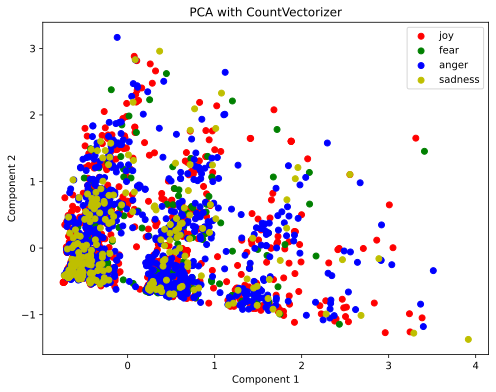

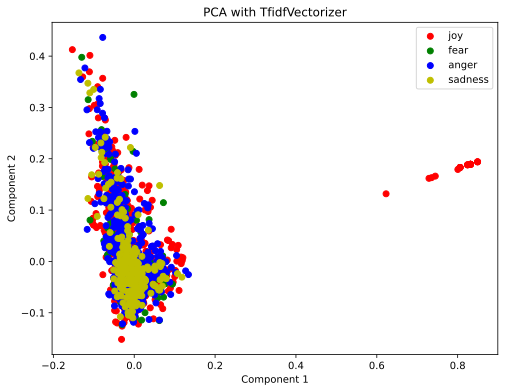

In [161]:
def plot_2d(data, labels, title):
    unique_labels = labels.unique()
    colors = ['r', 'g', 'b', 'y']  # 4 colors for 4 classes
    
    plt.figure(figsize=(8, 6))
    for i, label in enumerate(unique_labels):
        idx = labels == label
        plt.scatter(data[idx, 0], data[idx, 1], c=colors[i], label=label)
    
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.show()

# Plot for CountVectorizer
plot_2d(count_pca, labels, 'PCA with CountVectorizer')

# Plot for TfidfVectorizer
plot_2d(tfidf_pca, labels, 'PCA with TfidfVectorizer')

#### No class is visually seperable  